In [3]:
import numpy as np
from numpy import random
import random
import matplotlib.pyplot as plt
from scipy.signal import cwt,ricker
from scipy import stats
from sklearn.preprocessing import StandardScaler,normalize
from sklearn.preprocessing import MinMaxScaler
import os
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.optimizers
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.models import load_model
from tensorflow.keras.layers import Flatten,concatenate,Layer,Dense,LSTM,Activation,MaxPooling2D,Dropout,Conv2D,BatchNormalization,Reshape,UpSampling2D,ZeroPadding2D
import nibabel as nib
import pydicom as dicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import tensorflow_io as tfio
import radiomics
from radiomics.featureextractor import RadiomicsFeatureExtractor
import SimpleITK as sitk


# Training

In [2]:
#TF_ENABLE_ONEDNN_OPTS=0

#data used in this notebook from: https://www.kaggle.com/datasets/mehradaria/covid19-lung-ct-scans

In [4]:
dict = './covid19/training/'

# Function takes a list of folders, extract features from it, change the extractor inside function and the return dictionary
# to run exactly which feature, the key of the return dictionary can be found in mask.ipy and also listed in pyradiomics library
def LoadDataFromImages(foldernames):
    input_array = []
    output_array=[]

    extractor = RadiomicsFeatureExtractor()
    # Disable all classes except firstorder
    extractor.disableAllFeatures()
    extractor.enableFeaturesByName(ngtdm=['Strength'])  # change here to extract

    for i in foldernames:
        files  = os.listdir(dict + i)
        for j in files:
            im = sitk.ReadImage(dict + i +'/' + j)
            
            # reshape and fill the input array
            input_array.append(sitk.GetArrayFromImage(im).reshape(512,512,1))
            
            ma_arr = np.ones(im.GetSize()[::-1])  # reverse the order as image is xyz, array is zyx
            ma = sitk.GetImageFromArray(ma_arr)
            ma.CopyInformation(im)  # Copy geometric info
            
            # extract features and fill the output array
            features = extractor.execute(im, ma)
            
            output_array.append(features['original_ngtdm_Strength'])  # change here to extract

            
    return input_array, output_array

            

In [34]:
input_array, output_array = LoadDataFromImages(["trainingNon", "trainingPos"])

In [6]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

2022-07-28 08:48:43.995473: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-28 08:48:47.429231: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11560 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0000:0a:00.0, compute capability: 3.7
2022-07-28 08:48:47.431285: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 11560 MB memory:  -> device: 1, name: Tesla K80, pci bus id: 0000:0b:00.0, compute capability: 3.7


In [33]:
def MakeModel(modelname):
    input_layer = keras.Input(shape=(512,512,1))
    x = Flatten()(input_layer)
    x = BatchNormalization(axis=1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    out = Dense(1, activation = 'linear', name= modelname)(x)
    model = keras.Model(input_layer, out, name= modelname)
    
    return model

In [34]:
model = MakeModel('covid_RunLengthNonUniformity')

In [35]:
model.compile(optimizer=tf.keras.optimizers.Adam(
 #learning_rate= 0.0001
), loss="mse", metrics='mae')

In [83]:
model.fit(input_array, o4, 
              epochs=20, 
          batch_size=64,
                shuffle=True
            )

In [40]:
model.save("./covid_RunLengthNonUniformity.h5")

In [13]:
dict = './covid19/testing/'

input_array_t = []
output_array_t = []

input_array_t, output_array_t = LoadDataFromImages([
                                                    'non'

                                                   ])

In [14]:
input_array_t = np.array(input_array_t)
output_array_t = np.array(output_array_t)

10/10 [==============================] - 0s 7ms/step


Text(0.5, 1.0, 'covid_RunLengthNonUniformity')

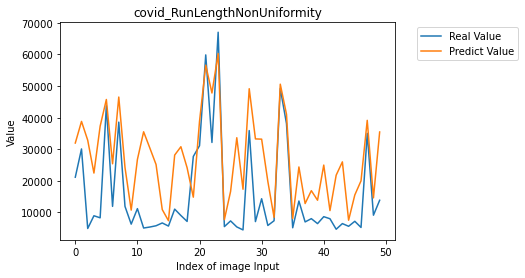

In [39]:
plt.plot(range(50),output_array_t[0:50] ,label='Real Value')
plt.plot(range(50),model.predict(input_array_t)[0:50]  ,label='Predict Value')
plt.xlabel("Index of image Input")
plt.ylabel("Value")
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left')
plt.title('covid_RunLengthNonUniformity')

#print(np.mean(test_array7, axis=1))

# Compare Performances - Simple Network

In [4]:
# class_names = ['non', 'pos']
# dict = './covid19/testing/'

class_names = ['Non-COVID-19', 'COVID-19']
dict = './covid19/wholeset/'

In [5]:

def load_training():
    trainingdata = []
    for i in class_names:
        path = os.path.join(dict, i)
        label_num = class_names.index(i)
        for j in os.listdir(path):
            img = sitk.ReadImage(dict + i +'/' + j)
            trainingdata.append([sitk.GetArrayFromImage(img).reshape(512,512,1),label_num])
            
    return trainingdata
    
            
    

In [6]:
data = load_training()

In [7]:
len(data)

8439

In [8]:
# mix the non and pos covid 19
random.shuffle(data)

In [33]:
X =[]
Y =[]
X_t = []
Y_t = []
for trainingx, label in data[:4000]:
    X.append(trainingx)
    Y.append(label)

In [34]:
for trainingx, label in data[4000:]:
    X_t.append(trainingx)
    Y_t.append(label)


In [35]:
X = np.array(X)
Y = np.array(Y)
X_t = np.array(X_t)
Y_t = np.array(Y_t)

In [37]:
print(Y[:10])

[1 1 0 1 0 1 1 1 0 1]


In [38]:
# creating a simple Network
def MakeModel(modelname):
    input_layer = keras.Input(shape=(512,512,1))
    x = Flatten()(input_layer)
    #x = BatchNormalization(axis=1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)

    out = Dense(2, activation = 'softmax', name= modelname)(x)

    model = keras.Model(input_layer, out, name= modelname)
    
    return model

In [39]:
simpleModel = MakeModel('simpleDLmodel')

In [40]:
simpleModel.compile(optimizer=tf.keras.optimizers.Adam(
 learning_rate= 0.0001
),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy']
                   )

In [41]:
history_sn = simpleModel.fit(X, Y, 
                validation_data=([X_t,Y_t]), 
                batch_size=64,
                epochs=20)


Epoch 1/20
63/63 [==============================] - 3s 36ms/step - loss: 245.8408 - accuracy: 0.8372 - val_loss: 24.3737 - val_accuracy: 0.9223
Epoch 2/20
63/63 [==============================] - 1s 16ms/step - loss: 43.2687 - accuracy: 0.9135 - val_loss: 9.3793 - val_accuracy: 0.9660
Epoch 3/20
63/63 [==============================] - 1s 16ms/step - loss: 40.5215 - accuracy: 0.9365 - val_loss: 107.2634 - val_accuracy: 0.6436
Epoch 4/20
63/63 [==============================] - 1s 17ms/step - loss: 42.7657 - accuracy: 0.9147 - val_loss: 23.7789 - val_accuracy: 0.9595
Epoch 5/20
63/63 [==============================] - 1s 16ms/step - loss: 33.6352 - accuracy: 0.9445 - val_loss: 11.5800 - val_accuracy: 0.9732
Epoch 6/20
63/63 [==============================] - 1s 16ms/step - loss: 120.5633 - accuracy: 0.9080 - val_loss: 30.3862 - val_accuracy: 0.9631
Epoch 7/20
63/63 [==============================] - 1s 16ms/step - loss: 9.1986 - accuracy: 0.9725 - val_loss: 7.9725 - val_accuracy: 0.9788

In [22]:
xx = X[7].reshape(1,512,512,1)

In [24]:
simpleModel.evaluate(X_t)

32/32 [==============================] - 0s 1ms/step - loss: 0.0000e+00


0.0

# Compare Performances - FINs

In [79]:
# loading FINs
# m1 = load_model('covid_SizeZoneNonUniformity.h5')
# m2 = load_model('covid_Contrast.h5')
# m3 = load_model('covid_LowGrayLevelEmphasis.h5')
# m4 = load_model('covid_Skewness.h5')
# m5 = load_model('covid_DependenceVariance.h5')
# m6= load_model('covid_GrayLevelVariance.h5')
# m7 = load_model('covid_Autocorrelation.h5')
# m8 = load_model('covid_RunLengthNonUniformity.h5')


def MakeModel(modelname):
    input_layer = keras.Input(shape=(512,512,1))
    l1 = m1(input_layer)
    l2 = m2(input_layer)
    l3 = m3(input_layer)
    l4 = m4(input_layer)
    l5 = m5(input_layer)
    l6 = m7(input_layer)
    l7 = m7(input_layer)
    l8 = m8(input_layer)
    
    #x = Flatten()(input_layer)
    n_d = concatenate([l1,l2
                       ,l4,l3,l5,l6,l7,l8
                      ])
    
    #x = Flatten()(n_d)
    #x = BatchNormalization(axis=1)(x)
    x = Dense(128, activation='relu')(n_d)
    x = Dense(128, activation='relu')(x)

    out = Dense(2, activation = 'softmax', name= modelname)(x)

    model = keras.Model(input_layer, out, name= modelname)
    
    return model

In [80]:
finModel1 = MakeModel('finModel')

In [81]:
finModel1.compile(optimizer=tf.keras.optimizers.Adam(
 learning_rate= 0.0001
),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']
                )

In [72]:
history_fin1 = finModel1.fit(X, Y, 
                validation_data=([X_t,Y_t]), 
                batch_size=64,
                epochs=20)

Epoch 1/20
63/63 [==============================] - 7s 80ms/step - loss: 36.5298 - accuracy: 0.9065 - val_loss: 2.4705 - val_accuracy: 0.9759
Epoch 2/20
63/63 [==============================] - 4s 57ms/step - loss: 0.5198 - accuracy: 0.9908 - val_loss: 1.9005 - val_accuracy: 0.9867
Epoch 3/20
63/63 [==============================] - 4s 56ms/step - loss: 0.2702 - accuracy: 0.9937 - val_loss: 1.7436 - val_accuracy: 0.9854
Epoch 4/20
63/63 [==============================] - 4s 57ms/step - loss: 0.0757 - accuracy: 0.9975 - val_loss: 2.2566 - val_accuracy: 0.9892
Epoch 5/20
63/63 [==============================] - 4s 57ms/step - loss: 0.0273 - accuracy: 0.9980 - val_loss: 1.9996 - val_accuracy: 0.9901
Epoch 6/20
63/63 [==============================] - 4s 57ms/step - loss: 0.0186 - accuracy: 0.9995 - val_loss: 1.7840 - val_accuracy: 0.9905
Epoch 7/20
63/63 [==============================] - 4s 57ms/step - loss: 0.0627 - accuracy: 0.9977 - val_loss: 1.8814 - val_accuracy: 0.9899
Epoch 8/20
6

In [62]:
# loading FINs
m1 = load_model('covid_SizeZoneNonUniformity.h5')
m2 = load_model('covid_Contrast.h5')
m3 = load_model('covid_LowGrayLevelEmphasis.h5')
m4 = load_model('covid_Skewness.h5')
m5 = load_model('covid_DependenceVariance.h5')
m6= load_model('covid_GrayLevelVariance.h5')
m7 = load_model('covid_Autocorrelation.h5')
m8 = load_model('covid_RunLengthNonUniformity.h5')


def MakeModel(modelname):
    input_layer = keras.Input(shape=(512,512,1))
    l1 = m1(input_layer)
    l2 = m2(input_layer)
    l3 = m3(input_layer)
    l4 = m4(input_layer)
    l5 = m5(input_layer)
    l6 = m7(input_layer)
    l7 = m7(input_layer)
    l8 = m8(input_layer)
    
    x_ori = Flatten()(input_layer)
    n_d = concatenate([x_ori, l1,l2
                       ,l4,l3,l5,l6,l7,l8
                      ])
    
    #x = Flatten()(n_d)
    #x = BatchNormalization(axis=1)(x)
    x = Dense(128, activation='relu')(n_d)
    x = Dense(128, activation='relu')(x)


    out = Dense(2, activation = 'softmax', name= modelname)(x)

    model = keras.Model(input_layer, out, name= modelname)
    
    return model

In [63]:
finModel2 = MakeModel('finModel')
finModel2.compile(optimizer=tf.keras.optimizers.Adam(
 learning_rate= 0.0001
),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']
                )
history_fin2 = finModel2.fit(X, Y, 
                validation_data=([X_t,Y_t]), 
                batch_size=64,
                epochs=20)

Epoch 1/20
63/63 [==============================] - 7s 83ms/step - loss: 255.4845 - accuracy: 0.8497 - val_loss: 49.9548 - val_accuracy: 0.9223
Epoch 2/20
63/63 [==============================] - 4s 59ms/step - loss: 52.5715 - accuracy: 0.8935 - val_loss: 22.0112 - val_accuracy: 0.8833
Epoch 3/20
63/63 [==============================] - 4s 59ms/step - loss: 24.5969 - accuracy: 0.9317 - val_loss: 37.4470 - val_accuracy: 0.7995
Epoch 4/20
63/63 [==============================] - 4s 60ms/step - loss: 22.3056 - accuracy: 0.9375 - val_loss: 11.6145 - val_accuracy: 0.9689
Epoch 5/20
63/63 [==============================] - 4s 59ms/step - loss: 1.9735 - accuracy: 0.9847 - val_loss: 1.9442 - val_accuracy: 0.9811
Epoch 6/20
63/63 [==============================] - 4s 59ms/step - loss: 32.7168 - accuracy: 0.9563 - val_loss: 6.1335 - val_accuracy: 0.9777
Epoch 7/20
63/63 [==============================] - 4s 59ms/step - loss: 9.7212 - accuracy: 0.9747 - val_loss: 7.9506 - val_accuracy: 0.9752
Epo

# Plot Graph

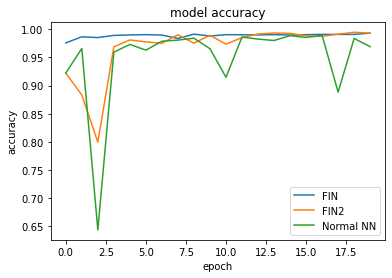

In [73]:


plt.plot(history_fin1.history['val_accuracy'])
plt.plot(history_fin2.history['val_accuracy'])
plt.plot(history_sn.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['FIN','FIN2' ,'Normal NN'], loc='lower right')
plt.show()

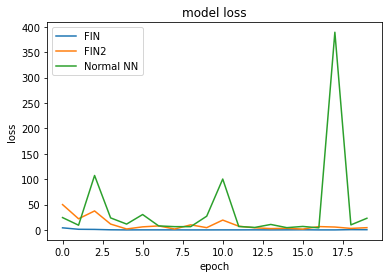

In [74]:
plt.plot(history_fin.history['val_loss'])
plt.plot(history_fin2.history['val_loss'])
plt.plot(history_sn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['FIN','FIN2', 'Normal NN'], loc='upper left')
plt.show()